In [1]:
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({"text.usetex": True})
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.rm'] = 'Helvetica'


import numpy as np
from nd2reader import ND2Reader
from scipy.optimize import curve_fit
from scipy.special import erf

In [2]:
# define gaussian shaped fit function
def skewed(x, a, c, w, alpha, off):
    return a*np.exp(-(c - x)**2/2/w**2) * (1 - erf((alpha*(c - x))/np.sqrt(2)/w)) + off

In [3]:
path= r"F:\Gebhard\Documents\Projects\ConstantCurrentITP\ITP.0011\project_data\experiments\2021-12-20\5µA\AF647_10ng_l"
path = path.replace("\\","/")
file = "005"
name = path + "/" + file
inname = "{}.nd2".format(name)

with ND2Reader(inname) as rawimages:
    rawimages.bundle_axes = 'yx' # defines which axes will be present in a single frame
    rawimages.iter_axes = 't' # defines which axes will be the index axis; z-axis is the time axis
    
    # determine metadata of the images
    height = rawimages.metadata["height"]
    width = rawimages.metadata["width"]
    nframes = rawimages.metadata["num_frames"]
    print(height, width)
    # Y x X x N
    data = np.zeros((height, width, nframes))
    
    # load image data into data array
    for frame in np.arange(0, len(rawimages), 1):
        data[:,:,frame] = rawimages[frame]
        
print(data.shape)        

152 512
(152, 512, 459)


In [4]:
fstrow = int(height / 2 - 27)
lstrow = int(height / 2 + 27)
data = data[fstrow:lstrow,:,:]

print (data.shape)

(54, 512, 459)


In [5]:
back = data[:,:,-11:nframes-1]
back = np.average(back, axis=2)

# subtract background fluorescence
data2 = np.zeros(data.shape)
for i in np.arange(0, nframes, 1):
    data2[:,:,i] = data[:,:,i] - back

In [6]:
avgdata = np.average(data2, axis=0)
avgdata = (avgdata-np.mean(avgdata))/np.std(avgdata)
print(avgdata.shape)

(512, 459)


In [7]:
x = np.linspace(1,avgdata.shape[0],avgdata.shape[0])#*1.6

first = 128
last = 275

pltdata1 = avgdata[:,first]

ast1 = np.max(pltdata1)
cst1 = np.argmax(pltdata1)#*1.6
wst1 = 1
alphast1 = 1
offst1 = np.average(pltdata1)
popt1, pcov1 = curve_fit(skewed,x,pltdata1,p0=[ast1,cst1,wst1,alphast1,offst1])
fit1 = skewed(x, *popt1)

pltdata2 = avgdata[:,last]

ast2 = np.max(pltdata2)
cst2 = np.argmax(pltdata2)#*1.6
wst2 = 1
alphast2 = 1
offst2 = np.average(pltdata2)
popt2, pcov1 = curve_fit(skewed,x,pltdata2,p0=[ast2,cst2,wst2,alphast2,offst2])
fit2 = skewed(x, *popt2)

[  1.8875293  110.95935134   8.39779977   1.5997832    0.25390124]


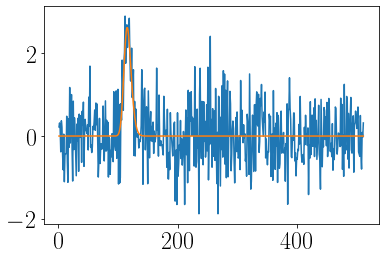

In [8]:
plt.plot(x,pltdata1-popt1[4],x,fit1-popt1[4])
print(popt1)

[  1.13812458 450.4740774    9.4784852    8.81297128   0.73670331]


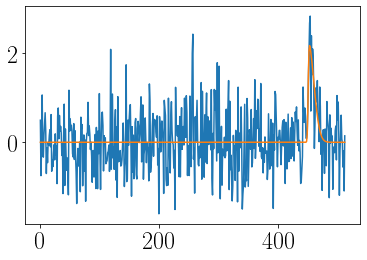

In [9]:
plt.plot(x,pltdata2-popt2[4],x,fit2-popt2[4])
print(popt2)

In [10]:
step = 46
fps = 46

vel = np.zeros(last-step-first+1)

for i in np.arange(first,last-step+1,1):
    pltdata1 = avgdata[:,i]

    ast1 = np.max(pltdata1)
    cst1 = np.argmax(pltdata1)#*1.6
    wst1 = 1
    alphast1 = 1
    offst1 = np.average(pltdata1)
    popt1, pcov1 = curve_fit(skewed,x,pltdata1,p0=[ast1,cst1,wst1,alphast1,offst1])
    fit1 = skewed(x, *popt1)

    pltdata2 = avgdata[:,i+step]

    ast2 = np.max(pltdata2)
    cst2 = np.argmax(pltdata2)#*1.6
    wst2 = 1
    alphast2 = 1
    offst2 = np.average(pltdata2)
    popt2, pcov1 = curve_fit(skewed,x,pltdata2,p0=[ast2,cst2,wst2,alphast2,offst2])
    fit2 = skewed(x, *popt2)
    
    x1 = np.argmax(fit1)#*1.6
    x2 = np.argmax(fit2)#*1.6
    
    
    vel[i-first] = ((x2-x1)) / (step/fps)
    
vel_avg=np.average(vel)
vel_std=np.std(vel) 

In [11]:
print(vel_avg, vel_std)

106.53921568627452 1.4119349025949124


In [12]:
width = np.zeros(last-first+1)

for i in np.arange(first,last+1,1):
    sampdata = avgdata[:,i]

    ast = np.max(sampdata)
    cst = np.argmax(sampdata) #*1.6
    wst = 1
    alphast = 1
    offst = np.average(sampdata)
    popt, pcov = curve_fit(skewed,x,sampdata,p0=[ast,cst,wst,alphast,offst])
    width[i-first] = popt[2]
    #print(i)
    
print(np.mean(width), np.std(width))    

8.351957904485777 1.5460326828427011


Text(0, 0.5, '$spread$')

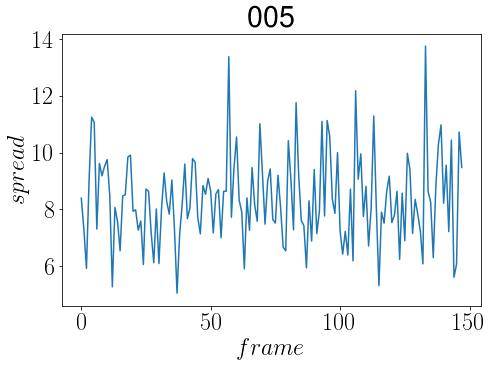

In [13]:
fr = np.arange(first,last+1,1) - first

fig = plt.figure(figsize=(7.5,5))
plt.plot(fr,width)
plt.title(file)
plt.xlabel('$frame$')
plt.ylabel('$spread$')
#plt.savefig(file + "png")

0.0017143025124989888


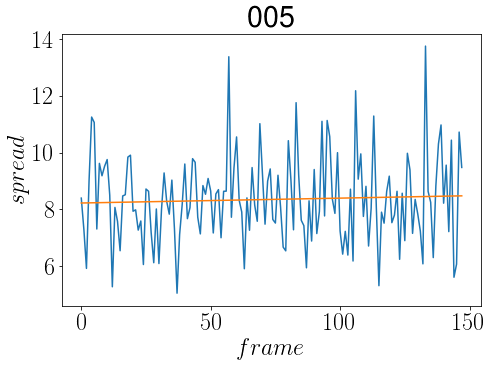

In [14]:
m,b = np.polyfit(fr,width,1)

fig = plt.figure(figsize=(7.5,5))
plt.plot(fr,width,fr,m*fr+b)
plt.title(file)
plt.xlabel('$frame$')
plt.ylabel('$spread$')
#plt.savefig(file + "_fit.png")

print(m)

[ 3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15. ]


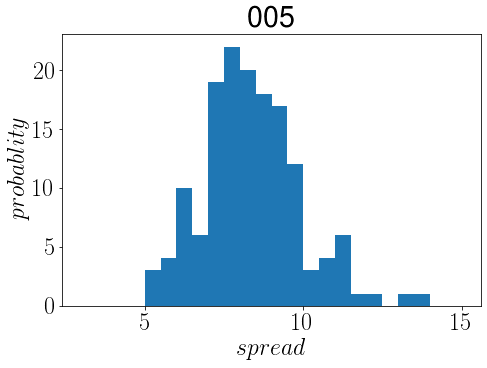

In [15]:
#bins1 = np.linspace(6,24,37)
bins1 = np.linspace(3,15,25)

fig = plt.figure(figsize=(7.5,5))
plt.hist(width, bins=bins1)
plt.title(file)
plt.xlabel('$spread$')
plt.ylabel('$probablity$')
#plt.savefig(file + "_hist.png")

print(bins1)

In [16]:
pltdata1 = avgdata[:,168]

ast1 = np.max(pltdata1)
cst1 = np.argmax(pltdata1)#*1.6
wst1 = 1
alphast1 = 1
offst1 = np.average(pltdata1)
popt1, pcov1 = curve_fit(skewed,x,pltdata1,p0=[ast1,cst1,wst1,alphast1,offst1])
fit1 = skewed(x, *popt1)

pltdata2 = avgdata[:,214]

ast2 = np.max(pltdata2)
cst2 = np.argmax(pltdata2)#*1.6
wst2 = 1
alphast2 = 1
offst2 = np.average(pltdata2)
popt2, pcov1 = curve_fit(skewed,x,pltdata2,p0=[ast2,cst2,wst2,alphast2,offst2])
fit2 = skewed(x, *popt2)

[  2.71865074 203.70748506   9.59900871   2.72822469  -1.15770969]


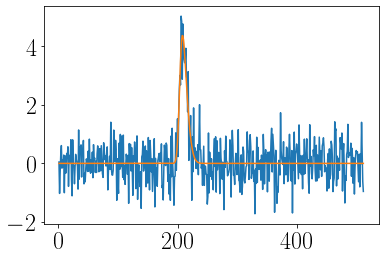

In [17]:
plt.plot(x,pltdata1-popt1[4],x,fit1-popt1[4])
print(popt1)

[  3.76857427 310.94440964   7.42849186   1.32779328  -0.74849948]


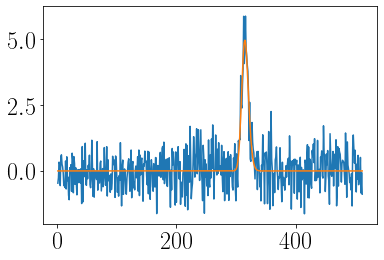

In [18]:
plt.plot(x,pltdata2-popt2[4],x,fit2-popt2[4])
print(popt2)

Text(0, 0.5, 'Occurance')

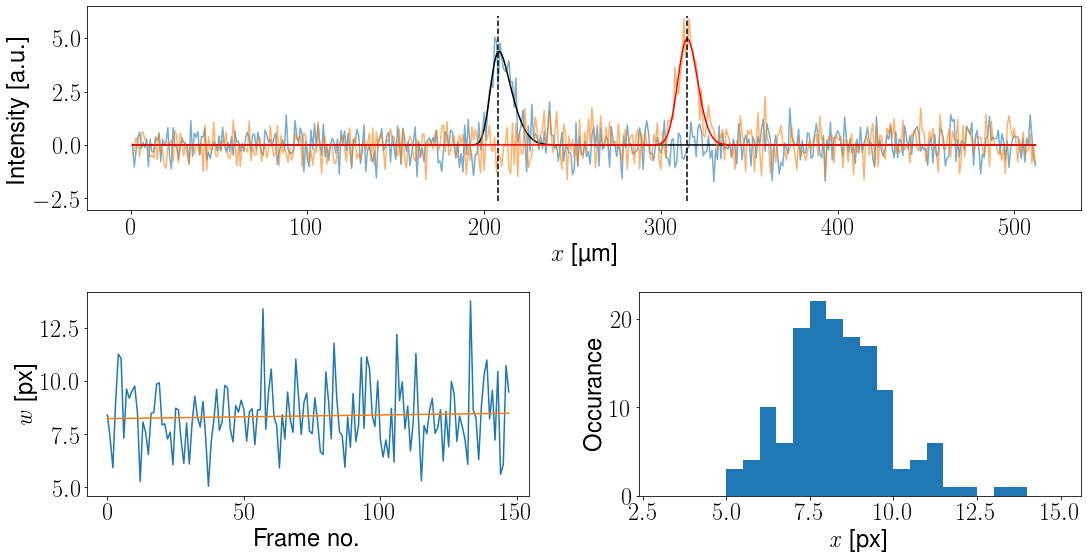

In [19]:
fig = plt.figure(figsize=(17.8, 9))

ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.25)

ax1.plot(x,pltdata1-popt1[4],alpha=0.6)
ax1.plot(x,fit1-popt1[4],"black")
ax1.plot(x,pltdata2-popt2[4],alpha=0.6)
ax1.plot(x,fit2-popt2[4],"red")
#ax1.plot([(np.argmax(fit1)+1)*1.6, (np.argmax(fit1)+1)*1.6], [np.min(pltdata2)-np.absolute(np.min(pltdata2)*0.1), np.max(pltdata2-popt2[4])+np.absolute(np.min(pltdata2-popt2[4])*0.1)],'--k')
#x1.plot([(np.argmax(fit2)+1)*1.6, (np.argmax(fit2)+1)*1.6], [np.min(pltdata2)-np.absolute(np.min(pltdata2)*0.1), np.max(pltdata2-popt2[4])+np.absolute(np.min(pltdata2-popt2[4])*0.1)],'--k')
ax1.plot([(np.argmax(fit1)+1), (np.argmax(fit1)+1)], [np.min(pltdata2)-np.absolute(np.min(pltdata2)*0.1), np.max(pltdata2-popt2[4])+np.absolute(np.min(pltdata2-popt2[4])*0.1)],'--k')
ax1.plot([(np.argmax(fit2)+1), (np.argmax(fit2)+1)], [np.min(pltdata2)-np.absolute(np.min(pltdata2)*0.1), np.max(pltdata2-popt2[4])+np.absolute(np.min(pltdata2-popt2[4])*0.1)],'--k')
ax1.set_xlabel('$x$ [µm]')
ax1.set_ylabel('Intensity [a.u.]')

ax2.plot(fr,width,fr,m*fr+b)
ax2.set_xlabel('Frame no.')
ax2.set_ylabel('$\mathit{w}$ [px]')

ax3.hist(width, bins=bins1)
ax3.set_xlabel('$\mathit{x}$ [px]')
ax3.set_ylabel('Occurance')

#plt.savefig("EstimationROPE.svg")